# Introduction
The project was to classify stocks from the stock market and group them into 3 clusters to find which stocks were performing best, average and worst. This was to be done using K-means Clustering. The dataset used can be found [HERE](https://www.kaggle.com/kp4920/s-p-500-stock-data-time-series-analysis/data).

Information about stock market analysis and Data Science was done from [Fool](https://www.fool.com/), [Investopedia](https://www.investopedia.com/), [preMBA_Columbia](http://ci.columbia.edu/ci/premba_test/c0332/s6/s6_4.html) and [Medium Daily](https://medium.com/uptick-blog)
## What is K-means clustering?
K-means clustering is a type of unsupervised learning model. Unsupervised models are used to learn from a data set that is not classified. It identifies commonalities in the data set and react based on the presence or absence of such commonalities in each data point.

## How does K-means clustering works?
1. K number of cluster centroids are initialized randomly
2. Data points that are near to the cluster centroids are assigned to that cluster
3. The centroids will then move to the average point in the cluster and the data points will be re-assigned again
4. Step 1 and 2 will be repeated until there is no change in the clusters.

Source: [HERE](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [58]:
df = pd.read_csv('all_stocks_5yr.csv')

In [59]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


> As we need to calculate the average returns for each stock for each year, we will create a column called Year. 

In [60]:
df = (
    df
    .pipe(lambda x: x.assign(Year=pd.to_datetime(x.Date).dt.year))
    .query("Year >= 2012")
    [['Name', 'Date', 'Year', 'Open', 'Close']]
)

In [61]:
df.head()

,Name,Date,Year,Open,Close
0,MMM,2012-08-13,2012,92.29,92.40
1,MMM,2012-08-14,2012,92.36,92.30
2,MMM,2012-08-15,2012,92.00,92.54
3,MMM,2012-08-16,2012,92.75,93.74
4,MMM,2012-08-17,2012,93.93,94.24


In [62]:
print(df.isnull().sum())

Name       0
Date       0
Year       0
Open     384
Close      0
dtype: int64


In [63]:
median = df['Open'].median()
df['Open'].fillna(median, inplace=True)

In [64]:
print(df.isnull().sum())

Name     0
Date     0
Year     0
Open     0
Close    0
dtype: int64


## Average yearly return can be calculated in 3 steps:
1. Calculate annual return of each year by subtracting the closing price of a stock on the last trading day in the year with the opening price of the same stock on the first trading day in the same year.
2. Divide the value in step 1 by the opening price of the stock on the first trading day in the same year. You would obtain the annual return for that year. Repeat step 1 and 2 for X number of years you have.
3. Sum up all the annual returns in the stated time period and divide the value by X number of years.

## To calculate variance:
1. Subtract each year's annual return with the average annual return and square that value.
2. Sum all the values in step 1 and divide it by X years.

In [65]:
# getting the first day and last day of each year that is available in the dataset
first_date_list = [df.query("Year == '{}'".format(2012+i)).Date.min() for i in range(6)]
last_date_list = [df.query("Year == '{}'".format(2012+i)).Date.max() for i in range(6)]
first_date_df = pd.DataFrame({"Date": first_date_list}) 
last_date_df = pd.DataFrame({"Date": last_date_list})

In [66]:
# filtering for the first day in dataset
first_date_df = (
    df
    .merge(first_date_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(year=x.Date.str[:4]))
    .rename(columns={"Open": "open_first_day"})
    .reset_index(drop=True)
    [['Name', 'Year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='Year', index='Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

# filtering last day in dataset 
last_date_df = (
    df
    .merge(last_date_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(year=x.Date.str[:4]))
    .rename(columns={"Close": "close_last_day"})
    .reset_index(drop=True)
    [['Name', 'Year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='Year', index='Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

In [67]:
first_date_df = first_date_df.dropna(how='any',axis=0) 
first_date_df.head()

,Name,2012,2013,2014,2015,2016,2017
0,A,40.27,42.17,57.10,41.18,41.06,45.93
2,AAP,68.51,73.49,110.36,160.85,149.25,170.78
3,AAPL,89.06,79.12,79.38,111.39,102.61,115.80
5,ABC,38.59,43.59,70.11,90.61,102.31,78.51
6,ABT,32.93,31.80,38.09,45.25,43.94,38.63


In [68]:
last_date_df = last_date_df.dropna(how='any',axis=0) 
last_date_df.head()

,Name,2012,2013,2014,2015,2016,2017
0,A,40.94,57.19,40.94,41.81,45.56,59.33
2,AAP,72.35,110.68,159.28,150.51,169.12,107.34
3,AAPL,76.02,80.15,110.38,105.26,115.82,157.48
4,ABBV,34.16,52.81,65.44,59.24,62.62,70.63
5,ABC,43.18,70.31,90.16,103.71,78.19,80.02


In [69]:
agg_first_date_df = (
    first_date_df
    .melt(id_vars='Name', value_vars=[2012, 2013, 2014, 2015, 2016, 2017])
    .rename(columns={"variable": "year", "value": "open_first_day"})
)

In [70]:
agg_last_date_df = (
    last_date_df
    .melt(id_vars='Name', value_vars=[2012, 2013, 2014, 2015, 2016, 2017])
    .rename(columns={"variable": "year", "value": "close_last_day"})
)

In [71]:
# calculating yearly return and then averaging them to get average yearly returns for each stock
agg_gains_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['Name', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    .groupby("Name")
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "avg_yearly_returns"})
)

# calculating overall variance using each year's return
agg_var_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['Name', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    [['Name', 'gains_pctg']]
    .groupby("Name")
    .agg(np.var)
    .reset_index()
    .rename(columns={"gains_pctg": "yearly_variance"})
)

agg_df = (
    agg_gains_df
    .merge(agg_var_df, on='Name', how='inner')
)

In [72]:
agg_df.head()

,Name,avg_yearly_returns,yearly_variance
0,A,0.084408,0.052370
1,AAP,0.117126,0.106653
2,AAPL,0.115128,0.048749
3,ABC,0.157660,0.079879
4,ABT,0.084164,0.022901


In [73]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459 entries, 0 to 458
Data columns (total 3 columns):
Name                  459 non-null object
avg_yearly_returns    459 non-null float64
yearly_variance       459 non-null float64
dtypes: float64(2), object(1)
memory usage: 14.3+ KB


# Modelling
## Evaluation

Typically, two metrics are used to evaluate a K-means model.

1. Sum of square errors (SSE) within clusters
2. Silhouette score.

SSE within clusters is derived by summing up the squared distance between each data point and its closest centroid. The goal is to reduce the error value. The intuition behind this is that we would want the distance of each data point to be as close as possible to the centroid. If the error is small, it would mean that the data points in the same cluster are relatively similar. As the number of centroids (clusters) increase, the error value will decrease. As such we would need to rely on the next metric to ensure that we are not introducing too many centroids (clusters) in the model.

Silhouette score is a measure of how similar the data point is to its own cluster compared to other clusters. The value ranges from -1 (worst score) to 1 (best score). A negative value would mean that data points are wrongly clustered while values near 0 would mean that there are overlapping clusters.

Source: [HERE](https://pdfs.semanticscholar.org/8785/b45c92622ebbbffee055aec198190c621b00.pdf)

In [74]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [75]:
def plot_cluster(df, max_loop=50):
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

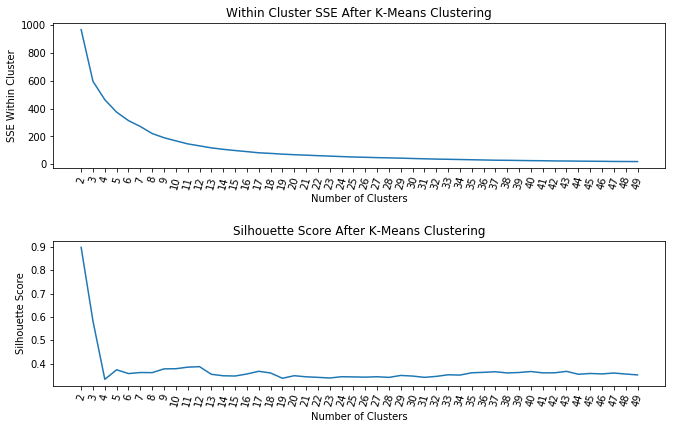

In [76]:
plot_cluster(agg_df, max_loop=50)

>From the first graph, ' Within Cluster SSE After K-Means Clustering ', we can see that as the number of clusters increase pass 50, the sum of square of errors within clusters plateaus off. From the second graph, ' Silhouette Score After K-Means Clustering ', we can see that there are various parts of the graph where a kink can be seen. Since there is not much a difference in SSE after 10 clusters and that the drop in sihouette score is quite significant between 2 clusters and 4 clusters, we will use 2 clusters in my K-Means model below.

In [77]:
def apply_cluster(df, clusters=2):
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance:")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [78]:
first_trial = apply_cluster(agg_df, clusters=2)

clustering performance:
silhouette score: 0.9
sse withing cluster: 969.0


In [79]:
first_trial.head()

,Name,avg_yearly_returns,yearly_variance,cluster
0,A,0.084408,0.052370,0
1,AAP,0.117126,0.106653,0
2,AAPL,0.115128,0.048749,0
3,ABC,0.157660,0.079879,0
4,ABT,0.084164,0.022901,0


In [80]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "Name":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df

,cluster,avg_yearly_returns,yearly_variance,Name
0,0,0.117425,0.058381,454
1,1,0.586210,0.892767,5


>From the dataframe above, we can see that the distribution of the stocks amongst the clusters is very skewed. Most of the stocks are aggregated in cluster 0. For the cluster 1, we can see that the avg_yearly_returns and variance are huge. As cluster 0 still contains too many stocks to choose from, we will attempt to conduct another K-Means clustering on cluster 0.

In [81]:
# creating a dataframe that only consists of cluster `0`
agg_df2 = agg_df.query("cluster == 0").reset_index(drop=True)

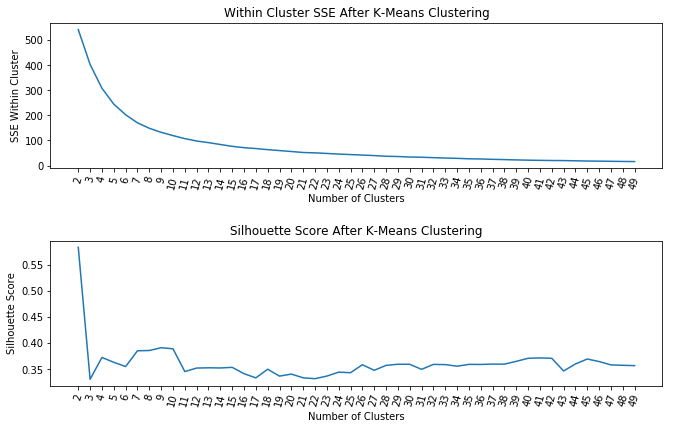

In [82]:
plot_cluster(agg_df2, max_loop=50)

>From the second graph,' Silhouette Score After K-Means Clustering ', we can see that there was a steep drop in silhouette score between 2 clusters and 3 clusters. As such, we will use 2 clusters in my K-Means model below.

In [83]:
second_trial= apply_cluster(agg_df2, clusters=2)

clustering performance:
silhouette score: 0.58
sse withing cluster: 543.0


In [84]:
cluster_perf_df2 = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "Name":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df2

,cluster,avg_yearly_returns,yearly_variance,Name
0,1,0.105493,0.040929,396
1,0,0.198891,0.177536,58


>From the dataframe above, we can see that cluster 1 has a good average yearly returns, with low variance compared to cluster 0, but cluster 1 still has too many stocks to choose from.
>Hence, we will use the Sharpe Ratio to determine which of the clusters is better performing

## What is Sharpe Ratio?

Sharpe Ratio is used to help investors understand the return of an investment compared to its risk. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. It is derived using annual returns, variance and risk-free rate. A Sharpe Ratio of more than 1 is considered good while a Sharpe Ratio of more than 2 is considered very good.

## How to compute Sharpe Ratio?

Sharpe Ratio can be computed as such:

$Sharpe\ Ratio = (R_s - R_f) /{SD_s}$

We will be using the first day of the year, 5-years daily U.S. yield rates, from [HERE](https://home.treasury.gov/) as the risk-free rate

Source: [HERE](https://www.investopedia.com/terms/s/sharperatio.asp)

In [85]:
# calculating the average risk free rate over the time period of 2012 - 2017
us_yield_curve_5years_dict = {"year": [2012, 2013, 2014, 2015, 2016, 2017],
                         "risk_free_rate": [0.89, 0.76, 1.72, 1.61, 1.73, 1.94]}
us_yield_curve_5years_df = pd.DataFrame.from_dict(us_yield_curve_5years_dict)

avg_risk_free_rate = (
    us_yield_curve_5years_df
    .mean()
    [['risk_free_rate']]
    [0]
)


In [86]:
def get_sharpe_ratio_df(df):
    """
    Computing Sharpe Ratio
    """
    df_w_sharpe_ratio = (
        df
        .pipe(lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate/100))
        .pipe(lambda x: x.assign(std_dev=np.sqrt(x.yearly_variance)))
        .pipe(lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns-x.avg_risk_free_rate)/x.std_dev))
    )

    return df_w_sharpe_ratio

In [87]:
second_trial_with_sharpe_ratio = get_sharpe_ratio_df(second_trial)

In [88]:
#Transforming dataframe so that I can plot a boxplot of `Returns`, `Variance` and `Sharpe Ratio` for each cluster
def get_transform_df(df_w_sharpe_ratio):
    df_yearly_returns = (
        df_w_sharpe_ratio
        [['avg_yearly_returns', 'cluster']]
        .pipe(lambda x: x.assign(type='avg_yearly_returns'))
        .rename(columns={"avg_yearly_returns": "rate"})
    )

    df_variance = (
        df_w_sharpe_ratio
        [['yearly_variance', 'cluster']]
        .pipe(lambda x: x.assign(type='yearly_variance'))
        .rename(columns={"yearly_variance": "rate"})
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [['sharpe_ratio', 'cluster']]
    )

    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    return df_transform, df_sharpe_ratio

In [89]:
cluster2_transform, cluster2_sharpe_ratio = get_transform_df(second_trial_with_sharpe_ratio)

In [90]:
#Plotting boxplot of cluster performance
def cluster_perf(transform_df, sharpe_ratio_df):
    _  = plt.figure(figsize=(15,7))

    ax1 = plt.subplot(121)
    _ = sns.boxplot(x='cluster', y='rate', hue='type', data=transform_df)
    _ = plt.title("Distribution of Returns and Variance for each Cluster")

    ax2 = plt.subplot(122)
    _ =sns.boxplot(x='cluster', y='sharpe_ratio', data=sharpe_ratio_df, color='royalblue')
    _ = plt.title("Distribution of Sharpe Ratio for each Cluster")

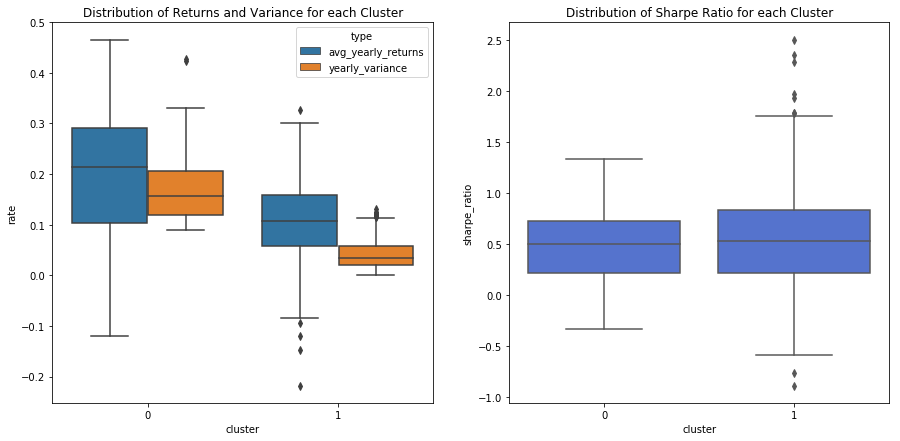

In [91]:
cluster_perf(cluster2_transform, cluster2_sharpe_ratio)

>Given that cluster 1 has the best Sharpe Ratio, we will perform one final trial using it.

In [92]:
(
    second_trial_with_sharpe_ratio
    .groupby("cluster")
    .agg({"avg_yearly_returns": "mean", "yearly_variance": "mean", "sharpe_ratio": "mean", "Name": "count"})
    .reset_index()
)

,cluster,avg_yearly_returns,yearly_variance,sharpe_ratio,Name
0,0,0.198891,0.177536,0.474873,58
1,1,0.105493,0.040929,0.555353,396


In [93]:
best_sub_cluster = second_trial.query("cluster == 1")

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


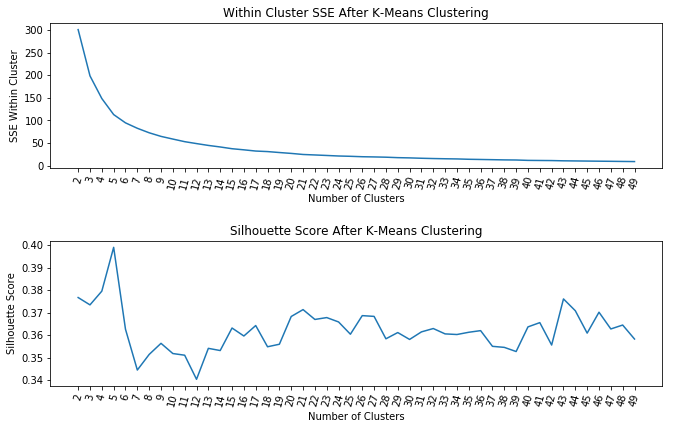

In [94]:
plot_cluster(best_sub_cluster, max_loop = 50)

>As both the curves have steep slopes between clusters 5 and 7, we will use 5 clusters for the third trial.

In [95]:
third_trial = apply_cluster(best_sub_cluster, 5)

clustering performance:
silhouette score: 0.4
sse withing cluster: 113.0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [96]:
best_sub_cluster_perf = (    
    third_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "Name":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
best_sub_cluster_perf

,cluster,avg_yearly_returns,yearly_variance,Name
0,0,-0.013816,0.110303,20
1,3,0.006302,0.038309,72
2,1,0.108105,0.020300,162
3,2,0.120187,0.073295,65
4,4,0.211332,0.041437,77


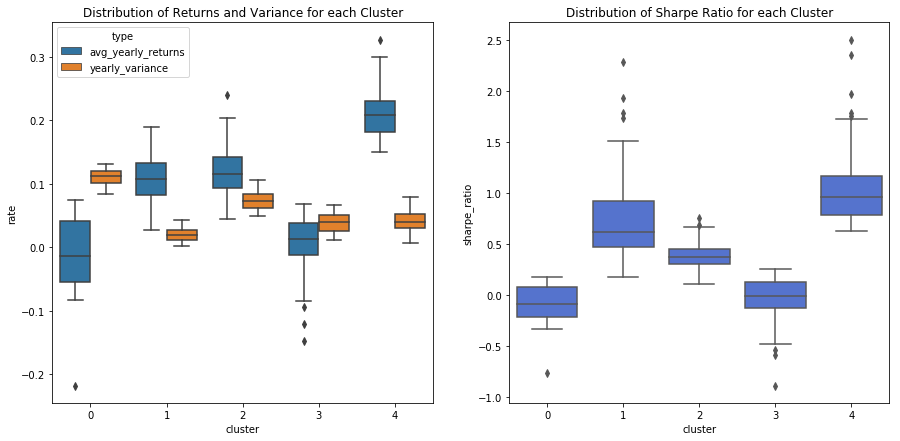

In [97]:
third_trial_w_sharpe_ratio = get_sharpe_ratio_df(third_trial)
best_sub_cluster_transform, best_sub_cluster_sharpe_ratio = get_transform_df(third_trial_w_sharpe_ratio)
cluster_perf(best_sub_cluster_transform, best_sub_cluster_sharpe_ratio)

In [98]:
(
    third_trial_w_sharpe_ratio
    .groupby('cluster')
    .agg({"avg_yearly_returns": "mean", "yearly_variance": "mean", "sharpe_ratio": "mean", "Name": "count"})
    .reset_index()
)

,cluster,avg_yearly_returns,yearly_variance,sharpe_ratio,Name
0,0,-0.013816,0.110303,-0.089245,20
1,1,0.108105,0.020300,0.729276,162
2,2,0.120187,0.073295,0.391937,65
3,3,0.006302,0.038309,-0.044052,72
4,4,0.211332,0.041437,1.055296,77


In [99]:
print("Below is the list of Stocks CLassifies as Best.\nThese can be invested in as they have the best average yearly returns and sharpe ration, \nwith better than average yearly variance.")
best_df = third_trial.query("cluster == 4").sort_values(by = ['avg_yearly_returns', 'yearly_variance'], ascending = False)
best_df.head()

Below is the list of Stocks CLassifies as Best.
These can be invested in as they have the best average yearly returns and sharpe ration, 
with better than average yearly variance.


,Name,avg_yearly_returns,yearly_variance,cluster
24,ALK,0.327026,0.079012,4
6,ADBE,0.300046,0.029507,4
259,LRCX,0.292821,0.050987,4
189,GPN,0.289269,0.038747,4
36,AOS,0.281011,0.048613,4


In [100]:
print("Below is the list of Stocks Classified as Average. \nThese perform better than the bad stocks, but are not as good as the best stocks.")
avg_df = third_trial.query("cluster == 2").sort_values(by = ['avg_yearly_returns', 'yearly_variance'], ascending = False)
avg_df.head()

Below is the list of Stocks Classified as Average. 
These perform better than the bad stocks, but are not as good as the best stocks.


,Name,avg_yearly_returns,yearly_variance,cluster
320,PCLN,0.240226,0.089303,2
409,UHS,0.202874,0.074121,2
193,GT,0.194864,0.071679,2
412,UNM,0.190374,0.071527,2
314,ORLY,0.187140,0.083270,2


In [103]:
print("Below is the list of Stocks Classified as Bad. \nThese have the worst performance of all the stocks in the dataset.")
bad_df = third_trial.query("cluster == 0").sort_values(by = ['avg_yearly_returns', 'yearly_variance'])
bad_df.head()

Below is the list of Stocks Classified as Bad. 
These have the worst performance of all the stocks in the dataset.


,Name,avg_yearly_returns,yearly_variance,cluster
308,NYSE:NBL,-0.217745,0.093695,0
37,APA,-0.082616,0.087413,0
288,MRO,-0.077685,0.114981,0
123,DISCA,-0.068810,0.123705,0
336,PPG,-0.055260,0.107134,0


In [102]:
import csv
export_csv = best_df.to_csv('Best Stock Picks.csv')
export_csv = avg_df.to_csv('Average Stock Picks.csv')
export_csv = bad_df.to_csv('Worst Stock Picks.csv')